In [1]:
import pandas as pd
from datetime import timedelta
import numpy as np

import xgboost as xgb # simple cv
from xgboost.sklearn import XGBClassifier # sklearn’s Grid Search with parallel processing
from xgboost import plot_importance

from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate  
from sklearn.model_selection import learning_curve, GridSearchCV

import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 16, 8
%matplotlib inline

In [4]:
#Load data:
train = pd.read_csv('D:/loan_prediction/Train_nyOWmfK.csv', encoding = "ISO-8859-1", engine='python')
test = pd.read_csv('D:/loan_prediction/Test.csv')

In [6]:
target = 'Disbursed'
IDcol = 'ID'

In [3]:
train.shape, test.shape

((87020, 26), (37717, 24))

In [4]:
train.dtypes

ID                        object
Gender                    object
City                      object
Monthly_Income             int64
DOB                       object
Lead_Creation_Date        object
Loan_Amount_Applied      float64
Loan_Tenure_Applied      float64
Existing_EMI             float64
Employer_Name             object
Salary_Account            object
Mobile_Verified           object
Var5                       int64
Var1                      object
Loan_Amount_Submitted    float64
Loan_Tenure_Submitted    float64
Interest_Rate            float64
Processing_Fee           float64
EMI_Loan_Submitted       float64
Filled_Form               object
Device_Type               object
Var2                      object
Source                    object
Var4                       int64
LoggedIn                   int64
Disbursed                  int64
dtype: object

In [6]:
#Combine into data:
train['source']= 'train'
test['source'] = 'test'
data=pd.concat([train, test],ignore_index=True, sort=False)
data.shape

(124737, 27)

## Check missing:

In [7]:
# data.apply(lambda x: sum(x.isnull()))

total = data.isnull().sum().sort_values(ascending=False)
percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
Processing_Fee,85346,0.684208
Interest_Rate,84901,0.680640
EMI_Loan_Submitted,84901,0.680640
Loan_Amount_Submitted,49535,0.397116
Loan_Tenure_Submitted,49535,0.397116
LoggedIn,37717,0.302372
Disbursed,37717,0.302372
Salary_Account,16801,0.134691
City,1401,0.011232
Employer_Name,113,0.000906


## Look at categories of all object variables:

In [7]:
var = ['Gender','Salary_Account','Mobile_Verified','Var1','Filled_Form','Device_Type','Var2','Source']
for v in var:
    print '\nFrequency count for variable %s'%v
    print data[v].value_counts()


Frequency count for variable Gender
Male      71398
Female    53339
Name: Gender, dtype: int64

Frequency count for variable Salary_Account
HDFC Bank                                          25180
ICICI Bank                                         19547
State Bank of India                                17110
Axis Bank                                          12590
Citibank                                            3398
Kotak Bank                                          2955
IDBI Bank                                           2213
Punjab National Bank                                1747
Bank of India                                       1713
Bank of Baroda                                      1675
Standard Chartered Bank                             1434
Canara Bank                                         1385
Union Bank of India                                 1330
Yes Bank                                            1120
ING Vysya                                            996
Corp

In [8]:
for col in list(data):
    print(col, ": ", data[col].nunique())

ID :  124737
Gender :  2
City :  723
Monthly_Income :  7366
DOB :  12230
Lead_Creation_Date :  92
Loan_Amount_Applied :  320
Loan_Tenure_Applied :  11
Existing_EMI :  4704
Employer_Name :  57194
Salary_Account :  58
Mobile_Verified :  2
Var5 :  19
Var1 :  19
Loan_Amount_Submitted :  213
Loan_Tenure_Submitted :  6
Interest_Rate :  74
Processing_Fee :  619
EMI_Loan_Submitted :  5361
Filled_Form :  2
Device_Type :  2
Var2 :  7
Source :  34
Var4 :  8
LoggedIn :  2
Disbursed :  2
source :  2


## Handle Individual Variables:

### City Variable:

In [28]:
len(data['City'].unique())
#drop city because too many unique
data.drop('City',axis=1,inplace=True)

### Determine Age from DOB

In [9]:
data['DOB'].head()

0    23-May-78
1    07-Oct-85
2    10-Oct-81
3    30-Nov-87
4    17-Feb-84
Name: DOB, dtype: object

In [9]:
#Create age variable:
data['Age'] = data['DOB'].apply(lambda x: 119 - int(x[-2:]))
data['Age'].head()

0    41
1    34
2    38
3    32
4    35
Name: Age, dtype: int64

In [10]:
#drop DOB:
data.drop('DOB',axis=1,inplace=True)

### EMI_Load_Submitted

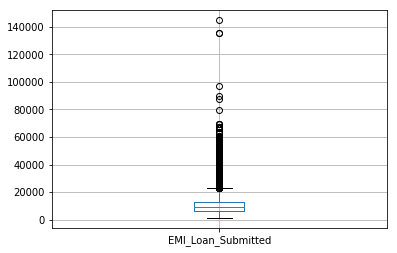

In [11]:
data.boxplot(column=['EMI_Loan_Submitted'],return_type='axes')

In [13]:
#Majority values missing so I'll create a new variable stating whether this is missing or note:
data['EMI_Loan_Submitted_Missing'] = data['EMI_Loan_Submitted'].apply(lambda x: 1 if pd.isnull(x) else 0)
# data['EMI_Loan_Submitted_Missing'] = np.where(data['EMI_Loan_Submitted'].isnull(), 1, 0)

data[['EMI_Loan_Submitted','EMI_Loan_Submitted_Missing']].head(10)

,EMI_Loan_Submitted,EMI_Loan_Submitted_Missing
0,NaN,1
1,6762.90,0
2,NaN,1
3,NaN,1
4,NaN,1
5,6978.92,0
6,NaN,1
7,NaN,1
8,30824.65,0
9,10883.38,0


In [12]:
#drop original vaiables:
data.drop('EMI_Loan_Submitted', axis=1, inplace=True)

### Employer Name

In [13]:
len(data['Employer_Name'].value_counts())

57194

In [14]:
data['Employer_Name'].value_counts()

0                                               6900
TATA CONSULTANCY SERVICES LTD (TCS)              754
COGNIZANT TECHNOLOGY SOLUTIONS INDIA PVT LTD     558
ACCENTURE SERVICES PVT LTD                       476
GOOGLE                                           408
ICICI BANK LTD                                   337
HCL TECHNOLOGIES LTD                             337
IBM CORPORATION                                  265
INDIAN AIR FORCE                                 258
INFOSYS TECHNOLOGIES                             257
INDIAN ARMY                                      243
GENPACT                                          240
WIPRO TECHNOLOGIES                               235
TYPE SLOWLY FOR AUTO FILL                        219
IKYA HUMAN CAPITAL SOLUTIONS LTD                 204
ARMY                                             203
INDIAN RAILWAY                                   201
HDFC BANK LTD                                    201
STATE GOVERNMENT                              

In [ ]:
data.Employer_Name.map(lambda x: x.count("LTD"))

In [15]:
#I'll drop the variable because too many unique values. Another option could be to categorize them manually
data.drop('Employer_Name',axis=1,inplace=True)

### Existing EMI

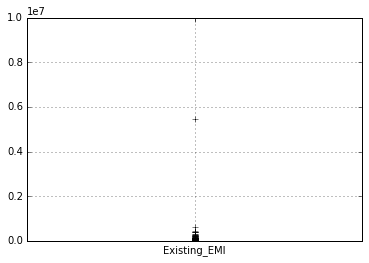

In [17]:
data.boxplot(column='Existing_EMI',return_type='axes')

In [16]:
data['Existing_EMI'].describe()

count    1.246260e+05
mean     3.636342e+03
std      3.369124e+04
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      3.500000e+03
max      1.000000e+07
Name: Existing_EMI, dtype: float64

In [ ]:
data.loc[(data.country == 'Italy') & (data.points >= 90)]

In [ ]:
data.loc[(data.country == 'Italy') | (data.points >= 90)]

In [ ]:
data.loc[(data.country.isin(['Italy', 'France'])]

In [ ]:
data.loc[data.Existing_EMI.notnull()]

In [17]:
#Impute by median (0) because just 111 missing:
data['Existing_EMI'].fillna(0, inplace=True)

In [ ]:
(data.points / data.price).idxmax()

### Interest Rate:

In [19]:
#Majority values missing so I'll create a new variable stating whether this is missing or note:
data['Interest_Rate_Missing'] = data['Interest_Rate'].apply(lambda x: 1 if pd.isnull(x) else 0)
data[['Interest_Rate','Interest_Rate_Missing']].head(10)

,Interest_Rate,Interest_Rate_Missing
0,NaN,1
1,13.25,0
2,NaN,1
3,NaN,1
4,NaN,1
5,13.99,0
6,NaN,1
7,NaN,1
8,14.85,0
9,18.25,0


In [20]:
data.drop('Interest_Rate',axis=1,inplace=True)

### Lead Creation Date:

In [21]:
#Drop this variable because doesn't appear to affect much intuitively
data.drop('Lead_Creation_Date',axis=1,inplace=True)

### Loan Amount and Tenure applied:

In [22]:
#Impute with median because only 111 missing:
data['Loan_Amount_Applied'].fillna(data['Loan_Amount_Applied'].median(),inplace=True)
data['Loan_Tenure_Applied'].fillna(data['Loan_Tenure_Applied'].median(),inplace=True)

### Loan Amount and Tenure selected

In [24]:
#High proportion missing so create a new var whether present or not
data['Loan_Amount_Submitted_Missing'] = data['Loan_Amount_Submitted'].apply(lambda x: 1 if pd.isnull(x) else 0)
data['Loan_Tenure_Submitted_Missing'] = data['Loan_Tenure_Submitted'].apply(lambda x: 1 if pd.isnull(x) else 0)

In [23]:
#Remove old vars
data.drop(['Loan_Amount_Submitted','Loan_Tenure_Submitted'],axis=1,inplace=True)

### Remove logged-in

In [24]:
data.drop('LoggedIn',axis=1,inplace=True)

### Remove salary account

In [30]:
#Salary account has mnay banks which have to be manually grouped
data.drop('Salary_Account',axis=1,inplace=True)

### Processing_Fee

In [25]:
#High proportion missing so create a new var whether present or not
data['Processing_Fee_Missing'] = data['Processing_Fee'].apply(lambda x: 1 if pd.isnull(x) else 0)
#drop old
data.drop('Processing_Fee',axis=1,inplace=True)

### Source

In [26]:
# data['Source'] = np.where(data['Source'].isin(['S122', 'S133']) == False, 'Sbrod', train['Source'])
data['Source'] = data['Source'].apply(lambda x: 'others' if x not in ['S122','S133'] else x)
data['Source'].value_counts()

S122      55249
S133      42900
others    26588
Name: Source, dtype: int64

## Final Data:

In [31]:
data.apply(lambda x: sum(x.isnull()))

ID                            0
Gender                        0
Monthly_Income                0
Loan_Amount_Applied           0
Loan_Tenure_Applied           0
Existing_EMI                  0
Mobile_Verified               0
Var5                          0
Var1                          0
Filled_Form                   0
Device_Type                   0
Var2                          0
Source                        0
Var4                          0
Disbursed                 37717
source                        0
Age                           0
Interest_Rate_Missing         0
Processing_Fee_Missing        0
dtype: int64

In [31]:
data.dtypes

Device_Type                       object
Disbursed                        float64
Existing_EMI                     float64
Filled_Form                       object
Gender                            object
ID                                object
Loan_Amount_Applied              float64
Loan_Tenure_Applied              float64
Mobile_Verified                   object
Monthly_Income                     int64
Source                            object
Var1                              object
Var2                              object
Var4                               int64
Var5                               int64
source                            object
Age                                int64
EMI_Loan_Submitted_Missing         int64
Interest_Rate_Missing              int64
Loan_Amount_Submitted_Missing      int64
Loan_Tenure_Submitted_Missing      int64
Processing_Fee_Missing             int64
dtype: object

### Numerical Coding:

In [32]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
var_to_encode = ['Device_Type','Filled_Form','Gender','Var1','Var2','Mobile_Verified','Source']
for col in var_to_encode:
    data[col] = le.fit_transform(data[col])

### One-Hot Coding

In [33]:
data = pd.get_dummies(data, columns=var_to_encode)
data.columns

Index(['ID', 'Monthly_Income', 'Loan_Amount_Applied', 'Loan_Tenure_Applied',
       'Existing_EMI', 'Var5', 'Var4', 'Disbursed', 'source', 'Age',
       'Interest_Rate_Missing', 'Processing_Fee_Missing', 'Device_Type_0',
       'Device_Type_1', 'Filled_Form_0', 'Filled_Form_1', 'Gender_0',
       'Gender_1', 'Var1_0', 'Var1_1', 'Var1_2', 'Var1_3', 'Var1_4', 'Var1_5',
       'Var1_6', 'Var1_7', 'Var1_8', 'Var1_9', 'Var1_10', 'Var1_11', 'Var1_12',
       'Var1_13', 'Var1_14', 'Var1_15', 'Var1_16', 'Var1_17', 'Var1_18',
       'Var2_0', 'Var2_1', 'Var2_2', 'Var2_3', 'Var2_4', 'Var2_5', 'Var2_6',
       'Mobile_Verified_0', 'Mobile_Verified_1', 'Source_0', 'Source_1',
       'Source_2'],
      dtype='object')

### Separate train & test:

In [34]:
train = data.loc[data['source']=='train']
test = data.loc[data['source']=='test']

In [35]:
train.drop('source',axis=1,inplace=True)
test.drop(['source','Disbursed'],axis=1,inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [116]:
train.to_csv('D:/loan_prediction/train_modified.csv',index=False)
test.to_csv('D:/loan_prediction/test_modified.csv',index=False)

In [2]:
train = pd.read_csv('D:/loan_prediction/train_modified.csv')
test = pd.read_csv('D:/loan_prediction/test_modified.csv')

In [44]:
test.head(5)

,ID,Monthly_Income,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Var5,Var4,Age,Interest_Rate_Missing,Processing_Fee_Missing,...,Var2_2,Var2_3,Var2_4,Var2_5,Var2_6,Mobile_Verified_0,Mobile_Verified_1,Source_0,Source_1,Source_2
87020,ID000026A10,21500,100000.0,3.0,0.0,3,3,32,0,0,...,0,0,0,0,0,0,1,1,0,0
87021,ID000054C40,42000,0.0,0.0,0.0,8,5,39,0,0,...,1,0,0,0,0,0,1,0,1,0
87022,ID000066O10,10000,300000.0,2.0,0.0,0,1,30,1,1,...,0,0,0,0,0,1,0,0,1,0
87023,ID000110G00,14650,0.0,0.0,0.0,0,1,28,1,1,...,1,0,0,0,0,1,0,0,1,0
87024,ID000113J30,23400,100000.0,1.0,5000.0,0,1,32,1,1,...,0,0,0,0,0,0,1,0,0,1


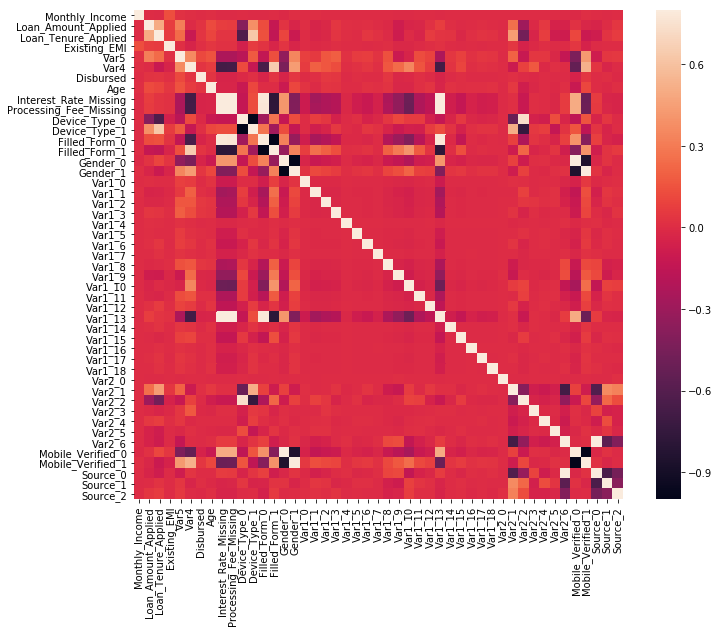

In [36]:
#correlation matrix
corrmat = data.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

In [ ]:
## Define a function for modeling and cross-validation

This function will do the following:
1. fit the model
2. determine training accuracy
3. determine training AUC
4. determine testing AUC
5. update n_estimators with cv function of xgboost package
6. plot Feature Importance 

In [3]:
def modelfit(alg, dtrain, dtest, predictors, useTrainCV=True, cv_folds=5, early_stopping_rounds = 50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        xgtest = xgb.DMatrix(dtest[predictors].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['Disbursed'],eval_metric='auc')      
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]    
   #Print model report:
    print('\nModel Report')
    print('Accuracy : ' , round(accuracy_score(dtrain['Disbursed'].values, dtrain_predictions), 3))
    print('AUC Score (Train): ' , round(roc_auc_score(dtrain['Disbursed'], dtrain_predprob), 3)) 
    print('N_estimators=: ' ,cvresult.shape[0])
    plot_importance(alg, )

In [7]:
predictors = [x for x in train.columns if x not in [target, IDcol]]

## 1_Learning rate and number of estimators 

In [47]:
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)


Model Report
Accuracy :  0.985
AUC Score (Train):  0.896
N_estimators=:  127


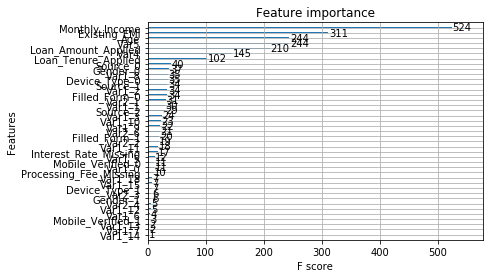

In [112]:
modelfit(xgb1, train, test, predictors)

## 2_Tune max_depth and min_child_weight

In [120]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=127, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(train[predictors],train[target])
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

({'mean_fit_time': array([28.27461724, 28.76224518, 23.37473693, 44.24573064, 42.81644897,
         38.0765779 , 59.57660756, 57.35728059, 58.08352218, 79.35753913,
         61.66532712, 58.59815164]),
  'std_fit_time': array([11.99547306, 12.5384996 ,  5.46148013, 19.12263766, 16.46871657,
          9.98063345, 23.60635154, 21.73568667, 15.55522281, 34.83725292,
         17.28463213, 16.67827759]),
  'mean_score_time': array([0.23721352, 0.16820955, 0.17361002, 0.1828105 , 0.25041437,
         0.18781075, 0.28101611, 0.25041432, 0.26741533, 0.37982163,
         0.27721577, 0.20361156]),
  'std_score_time': array([0.13774   , 0.02968941, 0.02069516, 0.01462137, 0.08071049,
         0.02072227, 0.07564297, 0.03812095, 0.03728258, 0.03335694,
         0.02232068, 0.04394165]),
  'param_max_depth': masked_array(data=[3, 3, 3, 5, 5, 5, 7, 7, 7, 9, 9, 9],
               mask=[False, False, False, False, False, False, False, False,
                     False, False, False, False],
         f

In [121]:
param_test2 = {
 'max_depth':[4,5,6],
 'min_child_weight':[1,2,5]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=5,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(train[predictors],train[target])
gsearch2.cv_results_, gsearch2.best_params_, gsearch2.best_score_

({'mean_fit_time': array([43.19647069, 32.04203262, 42.34962244, 41.18335557, 50.9775157 ,
         42.02420359, 59.93142786, 57.02826176, 38.92582645]),
  'std_fit_time': array([25.5651204 ,  8.18580233, 24.64169806, 11.92731621, 31.88717633,
         12.29169   , 29.54551384, 25.04517469,  6.03494899]),
  'mean_score_time': array([0.21441231, 0.19521127, 0.18741059, 0.20841198, 0.21561236,
         0.21261215, 0.20521169, 0.23661356, 0.22441278]),
  'std_score_time': array([0.05657392, 0.03360204, 0.01706098, 0.02821923, 0.05116775,
         0.03009216, 0.05075478, 0.03762438, 0.07435905]),
  'param_max_depth': masked_array(data=[4, 4, 4, 5, 5, 5, 6, 6, 6],
               mask=[False, False, False, False, False, False, False, False,
                     False],
         fill_value='?',
              dtype=object),
  'param_min_child_weight': masked_array(data=[1, 2, 5, 1, 2, 5, 1, 2, 5],
               mask=[False, False, False, False, False, False, False, False,
                    

## 3_Tune gamma

In [122]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=127, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(train[predictors],train[target])
gsearch3.cv_results_, gsearch3.best_params_, gsearch3.best_score_

({'mean_fit_time': array([47.27310395, 48.45397139, 52.02057543, 36.56069117, 36.03886127]),
  'std_fit_time': array([14.61941979, 15.33805022, 28.33164673, 12.71999092,  6.7603672 ]),
  'mean_score_time': array([0.22041259, 0.2520144 , 0.20201154, 0.21321225, 0.14940853]),
  'std_score_time': array([0.03271631, 0.04510246, 0.04557016, 0.07300663, 0.03723977]),
  'param_gamma': masked_array(data=[0.0, 0.1, 0.2, 0.3, 0.4],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'gamma': 0.0},
   {'gamma': 0.1},
   {'gamma': 0.2},
   {'gamma': 0.3},
   {'gamma': 0.4}],
  'split0_test_score': array([0.83019162, 0.83067158, 0.83100051, 0.83043114, 0.83052032]),
  'split1_test_score': array([0.83090871, 0.83010073, 0.82931161, 0.83149683, 0.82851495]),
  'split2_test_score': array([0.85497639, 0.85370701, 0.85373354, 0.85224177, 0.85204362]),
  'split3_test_score': array([0.84948515, 0.84919933, 0.84986166, 0.84784735, 0.8

## Before proceeding, re-calibrate the number of boosting rounds for the updated parameters.


Model Report
Accuracy :  0.985
AUC Score (Train):  0.896
N_estimators=:  127


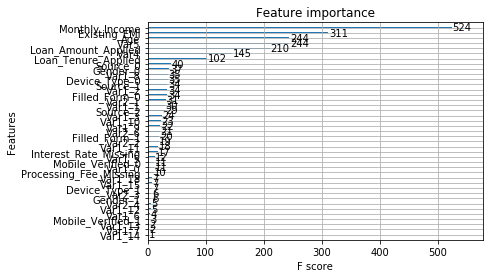

In [123]:
xgb2 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb2, train, test, predictors)

## 4_Tune subsample and colsample_bytree

In [124]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=127, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(train[predictors],train[target])
gsearch4.cv_results_, gsearch4.best_params_, gsearch4.best_score_

({'mean_fit_time': array([36.48128657, 37.06311984, 35.01780281, 30.31713395, 41.35956559,
         45.08877902, 36.11786575, 41.19015598, 52.46200085, 38.27638936,
         45.43919892, 47.84573679, 41.87439513, 50.73710198, 61.01608987,
         46.08063583]),
  'std_fit_time': array([12.76931563, 10.8777805 , 12.28619492,  9.52641927, 15.55672411,
         18.47189766, 11.44435812, 16.84627409, 23.27225937, 13.2123092 ,
         22.45123171, 19.99085043, 10.84057027, 22.73875643, 27.29855145,
         20.4449588 ]),
  'mean_score_time': array([0.22861309, 0.19561124, 0.21861253, 0.20841198, 0.19901142,
         0.22421279, 0.19141102, 0.21101193, 0.20001135, 0.20281162,
         0.21461234, 0.2762157 , 0.19221091, 0.21201215, 0.27201557,
         0.19821129]),
  'std_score_time': array([0.05549238, 0.02757398, 0.0483747 , 0.01890712, 0.02184622,
         0.04575154, 0.04103206, 0.04136899, 0.02124271, 0.04316448,
         0.05236561, 0.12413355, 0.01995492, 0.0352212 , 0.06532145,
 

## 5_Tuning Regularization Parameters

In [127]:
param_test5 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=127, max_depth=5,
 min_child_weight=1, gamma=0.1, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch5.fit(train[predictors],train[target])
gsearch5.cv_results_, gsearch5.best_params_, gsearch5.best_score_

({'mean_fit_time': array([45.85742288, 46.56966362, 40.60712256, 57.07506442, 29.74890156]),
  'std_fit_time': array([18.25975142, 14.67509966, 17.17239351, 23.07545216, 11.46062519]),
  'mean_score_time': array([0.24461393, 0.23341331, 0.23141322, 0.26221499, 0.13400774]),
  'std_score_time': array([0.05472641, 0.05229677, 0.08789728, 0.0360986 , 0.0425231 ]),
  'param_reg_alpha': masked_array(data=[1e-05, 0.01, 0.1, 1, 100],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'reg_alpha': 1e-05},
   {'reg_alpha': 0.01},
   {'reg_alpha': 0.1},
   {'reg_alpha': 1},
   {'reg_alpha': 100}],
  'split0_test_score': array([0.83067135, 0.83035203, 0.83203933, 0.83083645, 0.79261042]),
  'split1_test_score': array([0.83010095, 0.83005454, 0.82837981, 0.83473469, 0.79611285]),
  'split2_test_score': array([0.85370713, 0.85420541, 0.85281506, 0.85270244, 0.8204703 ]),
  'split3_test_score': array([0.84919933, 0.84817806, 0

In [128]:
param_test6 = {
 'reg_alpha':[0.8, .9, 1, 2,3]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=127, max_depth=5,
 min_child_weight=1, gamma=0.1, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test6, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch6.fit(train[predictors],train[target])
gsearch6.cv_results_, gsearch5.best_params_, gsearch5.best_score_

({'mean_fit_time': array([48.02494688, 49.00240278, 38.72701497, 43.39088168, 31.73661513]),
  'std_fit_time': array([22.80345088, 20.52069471, 10.74109791, 18.83081279,  8.77167995]),
  'mean_score_time': array([0.24581409, 0.19441099, 0.21661239, 0.21661243, 0.17140994]),
  'std_score_time': array([0.06490181, 0.0264862 , 0.04454738, 0.03609969, 0.06727824]),
  'param_reg_alpha': masked_array(data=[0.8, 0.9, 1, 2, 3],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'reg_alpha': 0.8},
   {'reg_alpha': 0.9},
   {'reg_alpha': 1},
   {'reg_alpha': 2},
   {'reg_alpha': 3}],
  'split0_test_score': array([0.83260664, 0.83367015, 0.83083645, 0.83204802, 0.83275619]),
  'split1_test_score': array([0.82844201, 0.83207717, 0.83473469, 0.83457417, 0.83277688]),
  'split2_test_score': array([0.85325995, 0.85507701, 0.85270244, 0.85336949, 0.8531718 ]),
  'split3_test_score': array([0.85139856, 0.85083058, 0.84993168, 0.8


Model Report
Accuracy :  0.985
AUC Score (Train):  0.892
N_estimators=:  127


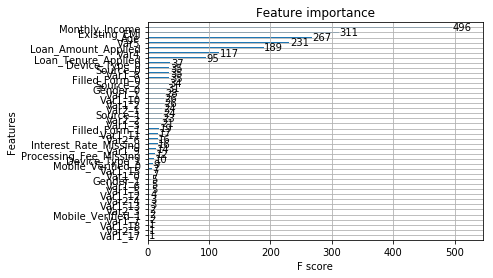

In [130]:
xgb3 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=127,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 reg_alpha=1,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb3, train, test, predictors)

## 6_Reducing Learning Rate


Model Report
Accuracy :  0.985
AUC Score (Train):  0.9
N_estimators=:  1402


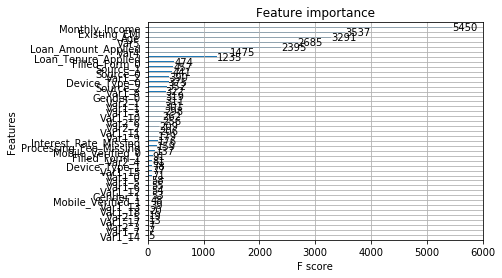

In [8]:
xgb4 = XGBClassifier(
 learning_rate =0.01,
 n_estimators=5000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 reg_alpha=1,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb4, train, test, predictors)


Model Report
Accuracy :  0.985
AUC Score (Train):  0.9
N_estimators=:  1402


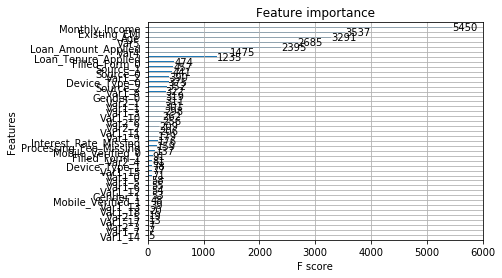

In [9]:
xgb5 = XGBClassifier(
 learning_rate =0.01,
 n_estimators=1402,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 reg_alpha=1,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb5, train, test, predictors)